In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random

# Target Model Architecture
class TargetModel(nn.Module):
    def __init__(self, n_features, n_classes):
        super(TargetModel, self).__init__()
        self.fc1 = nn.Linear(n_features, 256)
        self.fc2 = nn.Linear(256, n_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

# Synthetic Data Generator
class SyntheticDataGenerator:
    def __init__(self, n_features=600, n_classes=100):
        self.n_features = n_features
        self.n_classes = n_classes
        # Initialize target model properly
        self.target_model = TargetModel(n_features, n_classes)
        
    def initialize_with_random_data(self, n_records=1000):
        """Initialize target model with some random data first"""
        random_data = np.random.randint(0, 2, size=(n_records, self.n_features))
        random_labels = np.random.randint(0, self.n_classes, size=n_records)
        
        # Convert to PyTorch tensors
        X = torch.FloatTensor(random_data)
        y = torch.LongTensor(random_labels)
        
        # Train for a few epochs
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.target_model.parameters())
        
        for epoch in range(10):  # Just a few epochs for initialization
            self.target_model.train()
            optimizer.zero_grad()
            outputs = self.target_model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
        
        self.target_model.eval()  # Set to evaluation mode
        
    def generate_model_based_synthetic(self, n_records=10000, confidence_threshold=0.2, 
                                     max_iterations=1000, k_max=6, k_min=4, reject_max=10):
        """Implementation of Algorithm 1 from the paper"""
        # First make sure target model is initialized
        if not hasattr(self, 'target_model_initialized'):
            self.initialize_with_random_data()
            self.target_model_initialized = True
            
        synthetic_data = []
        synthetic_labels = []
        
        for target_class in range(self.n_classes):
            records_for_class = 0
            while records_for_class < n_records // self.n_classes:
                # Initialize random record
                x = np.random.randint(0, 2, size=self.n_features)  # Binary features
                k = k_max
                best_confidence = 0
                best_x = None
                consecutive_rejects = 0
                
                for _ in range(max_iterations):
                    # Query target model
                    with torch.no_grad():
                        pred = self.target_model(torch.FloatTensor(x).unsqueeze(0))
                        confidence = pred[0][target_class].item()
                    
                    if confidence > best_confidence:
                        best_confidence = confidence
                        best_x = x.copy()
                        consecutive_rejects = 0
                        
                        # Sample if confidence threshold met
                        if confidence > confidence_threshold and np.argmax(pred[0].numpy()) == target_class:
                            if random.random() < confidence:
                                synthetic_data.append(best_x)
                                synthetic_labels.append(target_class)
                                records_for_class += 1
                                break
                    else:
                        consecutive_rejects += 1
                        
                    # Adjust search space
                    if consecutive_rejects > reject_max:
                        k = max(k_min, k // 2)
                        consecutive_rejects = 0
                    
                    # Randomize k features
                    features_to_flip = np.random.choice(self.n_features, k, replace=False)
                    x = best_x.copy()
                    x[features_to_flip] = 1 - x[features_to_flip]
                    
        return np.array(synthetic_data), np.array(synthetic_labels)



# 3. Shadow Model (same architecture as target model)
class ShadowModel(nn.Module):
    def __init__(self, n_features, n_classes):
        super(ShadowModel, self).__init__()
        self.fc1 = nn.Linear(n_features, 256)
        self.fc2 = nn.Linear(256, n_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

# 4. Attack Model
class AttackModel(nn.Module):
    def __init__(self, n_classes):
        super(AttackModel, self).__init__()
        self.fc1 = nn.Linear(n_classes + 1, 64)  # +1 for true label
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# 5. Main MIA Implementation
class MembershipInferenceAttack:
    def __init__(self, n_features, n_classes, n_shadow_models=20):
        self.n_features = n_features
        self.n_classes = n_classes
        self.n_shadow_models = n_shadow_models
        self.target_model = None
        self.shadow_models = []
        self.attack_model = None
        
    def train_target_model(self, train_data, train_labels, epochs=100):
        self.target_model = TargetModel(self.n_features, self.n_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.target_model.parameters())
        
        for epoch in range(epochs):
            self.target_model.train()
            optimizer.zero_grad()
            outputs = self.target_model(torch.FloatTensor(train_data))
            loss = criterion(outputs, torch.LongTensor(train_labels))
            loss.backward()
            optimizer.step()
            
    def train_shadow_models(self, synthetic_data, synthetic_labels, epochs=100):
        # Split synthetic data for shadow models
        shadow_data_size = len(synthetic_data) // self.n_shadow_models
        
        for i in range(self.n_shadow_models):
            start_idx = i * shadow_data_size
            end_idx = (i + 1) * shadow_data_size
            
            shadow_train_data = synthetic_data[start_idx:end_idx]
            shadow_train_labels = synthetic_labels[start_idx:end_idx]
            
            # Train shadow model
            shadow_model = ShadowModel(self.n_features, self.n_classes)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(shadow_model.parameters())
            
            for epoch in range(epochs):
                shadow_model.train()
                optimizer.zero_grad()
                outputs = shadow_model(torch.FloatTensor(shadow_train_data))
                loss = criterion(outputs, torch.LongTensor(shadow_train_labels))
                loss.backward()
                optimizer.step()
                
            self.shadow_models.append(shadow_model)
            
    def prepare_attack_data(self):
        attack_data = []
        attack_labels = []
        
        # Generate attack training data from shadow models
        for shadow_model in self.shadow_models:
            # Generate predictions for members (training data)
            train_preds = shadow_model(torch.FloatTensor(train_data)).detach().numpy()
            for pred, true_label in zip(train_preds, train_labels):
                attack_input = np.concatenate([pred, [true_label]])
                attack_data.append(attack_input)
                attack_labels.append(1)  # Member
                
            # Generate predictions for non-members (test data)
            test_preds = shadow_model(torch.FloatTensor(test_data)).detach().numpy()
            for pred, true_label in zip(test_preds, test_labels):
                attack_input = np.concatenate([pred, [true_label]])
                attack_data.append(attack_input)
                attack_labels.append(0)  # Non-member
                
        return np.array(attack_data), np.array(attack_labels)
    
    def train_attack_model(self, attack_data, attack_labels, epochs=100):
        self.attack_model = AttackModel(self.n_classes)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.attack_model.parameters())
        
        for epoch in range(epochs):
            self.attack_model.train()
            optimizer.zero_grad()
            outputs = self.attack_model(torch.FloatTensor(attack_data))
            loss = criterion(outputs.squeeze(), torch.FloatTensor(attack_labels))
            loss.backward()
            optimizer.step()
            
    def perform_attack(self, data, labels):
        """Perform membership inference attack on given data"""
        self.attack_model.eval()
        with torch.no_grad():
            target_preds = self.target_model(torch.FloatTensor(data)).numpy()
            attack_inputs = np.array([np.concatenate([pred, [label]]) 
                                    for pred, label in zip(target_preds, labels)])
            membership_probs = self.attack_model(torch.FloatTensor(attack_inputs)).numpy()
        return membership_probs.squeeze() > 0.5
    


def main():
    # Initialize parameters
    n_features = 10  # For purchase dataset
    n_classes = 2
    n_records = 10
    
    # Create synthetic data generator
    print("Initializing synthetic data generator...")
    generator = SyntheticDataGenerator(n_features, n_classes)
    
    # Generate synthetic data
    print("Generating synthetic data...")
    synthetic_data, synthetic_labels = generator.generate_model_based_synthetic(n_records)
    
    print(f"Generated {len(synthetic_data)} synthetic records")
    print(f"Shape of synthetic data: {synthetic_data.shape}")
    print(f"Number of unique classes: {len(np.unique(synthetic_labels))}")
    
    # # Save the synthetic data (optional)
    # np.save('synthetic_data.npy', synthetic_data)
    # np.save('synthetic_labels.npy', synthetic_labels)
    # print("Saved synthetic data to files")

    df = pd.DataFrame(synthetic_data)
    df['label'] = synthetic_labels  
    print(df)
    
    # # Initialize MIA
    # mia = MembershipInferenceAttack(n_features, n_classes)
    
    # # Train target model
    # target_train_data, target_test_data, target_train_labels, target_test_labels = \
    #     train_test_split(synthetic_data, synthetic_labels, test_size=0.5)
    # mia.train_target_model(target_train_data, target_train_labels)
    
    # # Train shadow models
    # mia.train_shadow_models(synthetic_data, synthetic_labels)
    
    # # Prepare attack data
    # attack_data, attack_labels = mia.prepare_attack_data()
    
    # # Train attack model
    # mia.train_attack_model(attack_data, attack_labels)
    
    # # Perform attack
    # results = mia.perform_attack(target_test_data, target_test_labels)
    
    # # Calculate accuracy
    # accuracy = np.mean(results == (np.zeros_like(target_test_labels)))  # All test data are non-members
    # print(f"Attack Accuracy: {accuracy}")

if __name__ == "__main__":
    main()

Initializing synthetic data generator...
Generating synthetic data...
Generated 10 synthetic records
Shape of synthetic data: (10, 10)
Number of unique classes: 2
   0  1  2  3  4  5  6  7  8  9  label
0  1  0  1  1  1  1  0  1  0  1      0
1  0  0  0  1  0  1  1  0  0  0      0
2  1  1  1  1  1  1  1  0  0  0      0
3  0  0  0  1  1  1  0  0  0  0      0
4  0  1  0  1  1  0  0  0  0  1      0
5  1  1  1  1  1  0  0  0  1  1      1
6  1  1  1  0  1  0  0  0  1  0      1
7  0  1  1  1  0  0  0  0  1  1      1
8  0  0  1  0  0  0  1  0  1  0      1
9  1  0  1  1  0  0  1  0  0  0      1


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

def load_and_preprocess_adult():
    """Load and preprocess the Adult dataset with proper handling of categorical and continuous variables"""
    
    # Define column names
    columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
               'marital-status', 'occupation', 'relationship', 'race', 'sex',
               'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
    
    # Define column types
    continuous_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
                         'capital-loss', 'hours-per-week']
    categorical_features = ['workclass', 'education', 'marital-status', 'occupation',
                          'relationship', 'race', 'sex', 'native-country']
    
    # Load datasets
    print("Loading Adult dataset...")
    train_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                            names=columns, skipinitialspace=True)
    test_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                           names=columns, skipinitialspace=True, skiprows=1)
    
    # Combine for preprocessing
    data = pd.concat([train_data, test_data], ignore_index=True)
    
    # Clean data
    data = data.replace(' ?', np.nan)  # Replace ? with NaN
    data['income'] = data['income'].str.replace('.', '')  # Remove periods from income
    data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)  # Strip whitespace
    
    # Group rare categories
    for col in categorical_features:
        # Get value counts
        counts = data[col].value_counts()
        # Find rare categories (less than 1% of data)
        rare_cats = counts[counts/len(data) < 0.01].index
        # Replace rare categories with 'Other'
        if not rare_cats.empty:
            data[col] = data[col].replace(rare_cats, 'Other')
    
    # Create preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
        ('scaler', StandardScaler())  # Scale continuous variables
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))  # One-hot encoding, drop first to avoid collinearity
    ])

    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, continuous_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Prepare feature matrix
    X = data.drop('income', axis=1)
    
    # Transform features
    print("Transforming features...")
    X_transformed = preprocessor.fit_transform(X)
    
    # Get feature names after transformation
    numeric_features = continuous_features
    categorical_features_encoded = []
    for i, feature in enumerate(categorical_features):
        cats = preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_[i][1:]
        categorical_features_encoded.extend([f"{feature}_{cat}" for cat in cats])
    
    feature_names = numeric_features + categorical_features_encoded
    
    # Convert to DataFrame with proper column names
    X_transformed_df = pd.DataFrame(
        X_transformed, 
        columns=feature_names
    )
    
    # Transform target variable
    y = (data['income'].str.contains('>50K')).astype(int)
    
    # Convert to numpy arrays with proper types
    X_final = X_transformed_df.values.astype(np.float32)
    y_final = y.values.astype(np.int64)
    
    print(f"Final feature matrix shape: {X_final.shape}")
    print(f"Number of categorical features encoded: {len(categorical_features_encoded)}")
    print(f"Number of continuous features: {len(continuous_features)}")
    
    return X_final, y_final, feature_names, preprocessor

def main():
    # Load and preprocess data with proper handling
    X, y, feature_names, preprocessor = load_and_preprocess_adult()
    
    # Get dimensions for the model
    n_features = X.shape[1]
    n_classes = 2
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print("\nData Summary:")
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print(f"Number of features after preprocessing: {n_features}")
    print(f"Positive class distribution in training: {np.mean(y_train):.3f}")
    print(f"Positive class distribution in test: {np.mean(y_test):.3f}")
    
    # Save preprocessing information
    preprocessing_info = {
        'n_features': n_features,
        'n_classes': n_classes,
        'feature_names': feature_names,
        'preprocessor': preprocessor
    }
    
    return X_train, X_test, y_train, y_test, preprocessing_info

if __name__ == "__main__":
    X_train, X_test, y_train, y_test, preprocessing_info = main()

Loading Adult dataset...
Transforming features...
Final feature matrix shape: (48842, 58)
Number of categorical features encoded: 52
Number of continuous features: 6

Data Summary:
Training set shape: (39073, 58)
Test set shape: (9769, 58)
Number of features after preprocessing: 58
Positive class distribution in training: 0.239
Positive class distribution in test: 0.239


In [16]:
X_train

array([[-0.119879  ,  0.03259251,  1.136512  , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.2659334 ,  0.25540826, -0.8082971 , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.0471209 , -0.5936116 , -0.41933528, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.6306208 ,  0.37307546, -0.03037346, ...,  0.        ,
         0.        ,  1.        ],
       [-0.04694151, -1.0198498 ,  0.35858837, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.31774595, -0.71468776, -0.03037346, ...,  0.        ,
         0.        ,  1.        ]], dtype=float32)

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Target Model Architecture - Modified for preprocessed data
class TargetModel(nn.Module):
    def __init__(self, n_features):
        super(TargetModel, self).__init__()
        self.fc1 = nn.Linear(n_features, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.softmax(self.fc4(x))
        return x

# Shadow Model - Same architecture as target
class ShadowModel(TargetModel):
    pass

# Attack Model
class AttackModel(nn.Module):
    def __init__(self):
        super(AttackModel, self).__init__()
        self.fc1 = nn.Linear(3, 64)  # 2 class probabilities + 1 true label
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))
        return x

class MembershipInferenceAttack:
    def __init__(self, n_features, n_shadow_models=10):
        self.n_features = n_features
        self.n_shadow_models = n_shadow_models
        self.target_model = None
        self.shadow_models = []
        self.attack_model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def train_model(self, model, train_loader, test_loader, epochs=50):
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        best_acc = 0
        
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            
            train_acc = 100. * correct / total
            
            # Evaluation
            model.eval()
            test_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    test_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
                    
            test_acc = 100. * correct / total
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}]: Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%')
            
            if test_acc > best_acc:
                best_acc = test_acc
        
        return model, best_acc
    
    def train_target_model(self, train_data, train_labels, test_data, test_labels):
        print("\nTraining Target Model...")
        
        # Create data loaders
        train_dataset = TensorDataset(torch.FloatTensor(train_data), 
                                    torch.LongTensor(train_labels))
        test_dataset = TensorDataset(torch.FloatTensor(test_data), 
                                   torch.LongTensor(test_labels))
        
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=128)
        
        # Initialize and train model
        self.target_model = TargetModel(self.n_features)
        self.target_model, acc = self.train_model(self.target_model, train_loader, test_loader)
        print(f"Target Model Best Test Accuracy: {acc:.2f}%")
        
    def train_shadow_models(self, shadow_data, shadow_labels):
        print("\nTraining Shadow Models...")
        
        # Split shadow data for each model
        shadow_data_size = len(shadow_data) // self.n_shadow_models
        
        for i in range(self.n_shadow_models):
            start_idx = i * shadow_data_size
            end_idx = (i + 1) * shadow_data_size
            
            # Split data for this shadow model
            model_data = shadow_data[start_idx:end_idx]
            model_labels = shadow_labels[start_idx:end_idx]
            
            train_data, test_data, train_labels, test_labels = train_test_split(
                model_data, model_labels, test_size=0.5, stratify=model_labels
            )
            
            # Create data loaders
            train_dataset = TensorDataset(torch.FloatTensor(train_data), 
                                        torch.LongTensor(train_labels))
            test_dataset = TensorDataset(torch.FloatTensor(test_data), 
                                       torch.LongTensor(test_labels))
            
            train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=128)
            
            # Train shadow model
            shadow_model = ShadowModel(self.n_features)
            shadow_model, acc = self.train_model(shadow_model, train_loader, test_loader, epochs=30)
            self.shadow_models.append({
                'model': shadow_model,
                'train_data': train_data,
                'train_labels': train_labels,
                'test_data': test_data,
                'test_labels': test_labels
            })
            print(f"Shadow Model {i+1} Best Test Accuracy: {acc:.2f}%")
    
    def prepare_attack_data(self):
        print("\nPreparing Attack Data...")
        attack_data = []
        attack_labels = []
        
        for shadow_dict in self.shadow_models:
            shadow_model = shadow_dict['model']
            shadow_model.eval()
            
            with torch.no_grad():
                # Member data (training data)
                train_preds = shadow_model(torch.FloatTensor(shadow_dict['train_data']).to(self.device))
                train_preds = train_preds.cpu().numpy()
                
                for pred, true_label in zip(train_preds, shadow_dict['train_labels']):
                    attack_input = np.concatenate([pred, [true_label]])
                    attack_data.append(attack_input)
                    attack_labels.append(1)  # Member
                
                # Non-member data (test data)
                test_preds = shadow_model(torch.FloatTensor(shadow_dict['test_data']).to(self.device))
                test_preds = test_preds.cpu().numpy()
                
                for pred, true_label in zip(test_preds, shadow_dict['test_labels']):
                    attack_input = np.concatenate([pred, [true_label]])
                    attack_data.append(attack_input)
                    attack_labels.append(0)  # Non-member
        
        return np.array(attack_data), np.array(attack_labels)
    
    def train_attack_model(self, attack_data, attack_labels):
        print("\nTraining Attack Model...")
        
        # Create data loaders
        dataset = TensorDataset(torch.FloatTensor(attack_data), 
                              torch.FloatTensor(attack_labels))
        loader = DataLoader(dataset, batch_size=128, shuffle=True)
        
        self.attack_model = AttackModel()
        self.attack_model = self.attack_model.to(self.device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.attack_model.parameters(), lr=0.001)
        
        for epoch in range(30):
            self.attack_model.train()
            total_loss = 0
            correct = 0
            total = 0
            
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.attack_model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            acc = 100. * correct / total
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/30] Loss: {total_loss/len(loader):.4f} Acc: {acc:.2f}%')
    
    def perform_attack(self, data, labels):
        print("\nPerforming Attack...")
        self.target_model.eval()
        self.attack_model.eval()
        
        with torch.no_grad():
            target_preds = self.target_model(torch.FloatTensor(data).to(self.device))
            target_preds = target_preds.cpu().numpy()
            
            attack_inputs = np.array([np.concatenate([pred, [label]]) 
                                    for pred, label in zip(target_preds, labels)])
            
            membership_probs = self.attack_model(torch.FloatTensor(attack_inputs).to(self.device))
            membership_probs = membership_probs.cpu().numpy()
            
        return membership_probs.squeeze() > 0.5

def main():
    # Load and preprocess Adult dataset
    # [Previous preprocessing code remains the same]
    X, y, feature_names, preprocessor = load_and_preprocess_adult()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Initialize MIA
    mia = MembershipInferenceAttack(n_features=X.shape[1], n_shadow_models=10)
    
    # Train target model
    mia.train_target_model(X_train, y_train, X_test, y_test)
    
    # Generate synthetic shadow data using the preprocessed feature distributions
    # For demonstration, we'll use bootstrap samples from the test set
    shadow_data = np.vstack([X_test[np.random.choice(len(X_test), size=len(X_test), replace=True)] 
                            for _ in range(10)])
    shadow_labels = np.hstack([y_test[np.random.choice(len(y_test), size=len(y_test), replace=True)] 
                             for _ in range(10)])
    
    # Train shadow models
    mia.train_shadow_models(shadow_data, shadow_labels)
    
    # Prepare attack data
    attack_data, attack_labels = mia.prepare_attack_data()
    
    # Train attack model
    mia.train_attack_model(attack_data, attack_labels)
    
    # Perform attack and evaluate
    print("\nEvaluating Attack Performance...")
    
    # Test set results (should predict non-members)
    test_results = mia.perform_attack(X_test, y_test)
    test_accuracy = np.mean(test_results == 0)
    print(f"\nTest Set Attack Results:")
    print(f"Accuracy on test set (should predict non-members): {test_accuracy:.4f}")
    
    # Training set results (should predict members)
    train_results = mia.perform_attack(X_train, y_train)
    train_accuracy = np.mean(train_results == 1)
    print(f"\nTraining Set Attack Results:")
    print(f"Accuracy on training set (should predict members): {train_accuracy:.4f}")
    
    # Calculate additional metrics
    true_positives = np.sum(train_results == 1)
    false_positives = np.sum(test_results == 1)
    true_negatives = np.sum(test_results == 0)
    false_negatives = np.sum(train_results == 0)
    
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print(f"\nOverall Attack Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

if __name__ == "__main__":
    main()

Loading Adult dataset...
Transforming features...
Final feature matrix shape: (48842, 58)
Number of categorical features encoded: 52
Number of continuous features: 6

Training Target Model...
Epoch [10/50]: Train Acc: 86.37% Test Acc: 86.10%
Epoch [20/50]: Train Acc: 87.05% Test Acc: 86.08%
Epoch [30/50]: Train Acc: 87.47% Test Acc: 86.16%
Epoch [40/50]: Train Acc: 87.60% Test Acc: 85.87%
Epoch [50/50]: Train Acc: 87.93% Test Acc: 85.52%
Target Model Best Test Accuracy: 86.26%

Training Shadow Models...
Epoch [10/30]: Train Acc: 76.39% Test Acc: 76.40%
Epoch [20/30]: Train Acc: 76.39% Test Acc: 76.40%
Epoch [30/30]: Train Acc: 76.39% Test Acc: 76.40%
Shadow Model 1 Best Test Accuracy: 76.40%
Epoch [10/30]: Train Acc: 76.47% Test Acc: 76.48%
Epoch [20/30]: Train Acc: 76.47% Test Acc: 76.48%
Epoch [30/30]: Train Acc: 76.47% Test Acc: 76.48%
Shadow Model 2 Best Test Accuracy: 76.48%
Epoch [10/30]: Train Acc: 76.04% Test Acc: 76.03%
Epoch [20/30]: Train Acc: 76.04% Test Acc: 76.03%
Epoch [

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris

def load_and_preprocess_iris():
    """Load and preprocess the Iris dataset"""
    
    # Load iris dataset
    iris = load_iris()
    X = iris.data
    y = iris.target
    
    # Convert to float32 for PyTorch
    X = X.astype(np.float32)
    y = y.astype(np.int64)
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y

# Target Model Architecture
class TargetModel(nn.Module):
    def __init__(self, n_features):
        super(TargetModel, self).__init__()
        self.fc1 = nn.Linear(n_features, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 3)  # 3 classes for iris
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

# Shadow Model - Same architecture as target
class ShadowModel(TargetModel):
    pass

# Attack Model
class AttackModel(nn.Module):
    def __init__(self):
        super(AttackModel, self).__init__()
        self.fc1 = nn.Linear(4, 32)  # 3 class probabilities + 1 true label
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))
        return x

class MembershipInferenceAttack:
    def __init__(self, n_features, n_shadow_models=5):
        self.n_features = n_features
        self.n_shadow_models = n_shadow_models
        self.target_model = None
        self.shadow_models = []
        self.attack_model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def train_model(self, model, train_loader, test_loader, epochs=50):
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        best_acc = 0
        
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            
            train_acc = 100. * correct / total
            
            # Evaluation
            model.eval()
            test_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    test_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
                    
            test_acc = 100. * correct / total
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}]: Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%')
            
            if test_acc > best_acc:
                best_acc = test_acc
        
        return model, best_acc

    def train_target_model(self, train_data, train_labels, test_data, test_labels):
        print("\nTraining Target Model...")
        
        # Create data loaders
        train_dataset = torch.utils.data.TensorDataset(
            torch.FloatTensor(train_data), 
            torch.LongTensor(train_labels)
        )
        test_dataset = torch.utils.data.TensorDataset(
            torch.FloatTensor(test_data), 
            torch.LongTensor(test_labels)
        )
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
        
        # Initialize and train model
        self.target_model = TargetModel(self.n_features)
        self.target_model, acc = self.train_model(self.target_model, train_loader, test_loader)
        print(f"Target Model Best Test Accuracy: {acc:.2f}%")

    def train_shadow_models(self, shadow_data, shadow_labels):
        print("\nTraining Shadow Models...")
        
        shadow_data_size = len(shadow_data) // self.n_shadow_models
        
        for i in range(self.n_shadow_models):
            start_idx = i * shadow_data_size
            end_idx = (i + 1) * shadow_data_size
            
            model_data = shadow_data[start_idx:end_idx]
            model_labels = shadow_labels[start_idx:end_idx]
            
            train_data, test_data, train_labels, test_labels = train_test_split(
                model_data, model_labels, test_size=0.5, stratify=model_labels
            )
            
            # Create data loaders
            train_dataset = torch.utils.data.TensorDataset(
                torch.FloatTensor(train_data), 
                torch.LongTensor(train_labels)
            )
            test_dataset = torch.utils.data.TensorDataset(
                torch.FloatTensor(test_data), 
                torch.LongTensor(test_labels)
            )
            
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
            
            # Train shadow model
            shadow_model = ShadowModel(self.n_features)
            shadow_model, acc = self.train_model(shadow_model, train_loader, test_loader, epochs=30)
            self.shadow_models.append({
                'model': shadow_model,
                'train_data': train_data,
                'train_labels': train_labels,
                'test_data': test_data,
                'test_labels': test_labels
            })
            print(f"Shadow Model {i+1} Best Test Accuracy: {acc:.2f}%")
    
    def prepare_attack_data(self):
        print("\nPreparing Attack Data...")
        attack_data = []
        attack_labels = []
        
        for shadow_dict in self.shadow_models:
            shadow_model = shadow_dict['model']
            shadow_model.eval()
            
            with torch.no_grad():
                # Member data (training data)
                train_preds = shadow_model(torch.FloatTensor(shadow_dict['train_data']).to(self.device))
                train_preds = train_preds.cpu().numpy()
                
                for pred, true_label in zip(train_preds, shadow_dict['train_labels']):
                    attack_input = np.concatenate([pred, [true_label]])
                    attack_data.append(attack_input)
                    attack_labels.append(1)  # Member
                
                # Non-member data (test data)
                test_preds = shadow_model(torch.FloatTensor(shadow_dict['test_data']).to(self.device))
                test_preds = test_preds.cpu().numpy()
                
                for pred, true_label in zip(test_preds, shadow_dict['test_labels']):
                    attack_input = np.concatenate([pred, [true_label]])
                    attack_data.append(attack_input)
                    attack_labels.append(0)  # Non-member
        
        return np.array(attack_data), np.array(attack_labels)
    
    def train_attack_model(self, attack_data, attack_labels):
        print("\nTraining Attack Model...")
        
        # Create data loaders
        dataset = torch.utils.data.TensorDataset(
            torch.FloatTensor(attack_data), 
            torch.FloatTensor(attack_labels)
        )
        loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
        
        self.attack_model = AttackModel()
        self.attack_model = self.attack_model.to(self.device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.attack_model.parameters(), lr=0.001)
        
        for epoch in range(30):
            self.attack_model.train()
            total_loss = 0
            correct = 0
            total = 0
            
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.attack_model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            acc = 100. * correct / total
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/30] Loss: {total_loss/len(loader):.4f} Acc: {acc:.2f}%')
    
    def perform_attack(self, data, labels):
        print("\nPerforming Attack...")
        self.target_model.eval()
        self.attack_model.eval()
        
        with torch.no_grad():
            target_preds = self.target_model(torch.FloatTensor(data).to(self.device))
            target_preds = target_preds.cpu().numpy()
            
            attack_inputs = np.array([np.concatenate([pred, [label]]) 
                                    for pred, label in zip(target_preds, labels)])
            
            membership_probs = self.attack_model(torch.FloatTensor(attack_inputs).to(self.device))
            membership_probs = membership_probs.cpu().numpy()
            
        return membership_probs.squeeze() > 0.5

def main():
    # Load and preprocess Iris dataset
    X, y = load_and_preprocess_iris()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Initialize MIA
    mia = MembershipInferenceAttack(n_features=X.shape[1], n_shadow_models=5)
    
    # Train target model
    mia.train_target_model(X_train, y_train, X_test, y_test)
    
    # Generate synthetic shadow data using hill climbing
    def generate_synthetic_record(target_class, model, feature_ranges):
        """Generate a synthetic record using hill climbing that model classifies as target_class"""
        # Initialize parameters
        k_max = X.shape[1]  # Start with modifying all features
        k_min = 1  # Minimum number of features to modify
        rej_max = 5  # Max consecutive rejections before reducing k
        conf_min = 0.8  # Minimum confidence threshold
        max_iter = 100  # Maximum iterations
        
        # Initialize record randomly within feature ranges
        x = np.random.uniform(feature_ranges[:, 0], feature_ranges[:, 1])
        best_x = x.copy()
        best_conf = 0
        k = k_max
        consecutive_rejects = 0
        
        for _ in range(max_iter):
            # Get model prediction
            with torch.no_grad():
                pred = model(torch.FloatTensor(x.reshape(1, -1)).to(model.device))
                pred = pred.cpu().numpy()[0]
            
            conf = pred[target_class]
            
            # Accept if better than previous best
            if conf > best_conf:
                if conf > conf_min and np.argmax(pred) == target_class:
                    # Return if confidence threshold met
                    return x, True
                    
                best_x = x.copy()
                best_conf = conf
                consecutive_rejects = 0
            else:
                consecutive_rejects += 1
                
                # Reduce k if too many consecutive rejections
                if consecutive_rejects > rej_max:
                    k = max(k_min, k // 2)
                    consecutive_rejects = 0
            
            # Generate new candidate by modifying k random features
            x = best_x.copy()
            features_to_modify = np.random.choice(X.shape[1], k, replace=False)
            for feat in features_to_modify:
                x[feat] = np.random.uniform(feature_ranges[feat, 0], feature_ranges[feat, 1])
        
        return best_x, False

    # Calculate feature ranges for synthetic data generation
    feature_ranges = np.vstack([np.min(X, axis=0), np.max(X, axis=0)]).T
    
    # Generate synthetic shadow data
    synthetic_data = []
    synthetic_labels = []
    required_samples = len(X_test) * 10  # Same total size as before
    samples_per_class = required_samples // len(np.unique(y))
    
    print("\nGenerating synthetic shadow data using hill climbing...")
    for target_class in range(len(np.unique(y))):
        successful = 0
        attempts = 0
        while successful < samples_per_class and attempts < samples_per_class * 2:
            x, success = generate_synthetic_record(target_class, mia.target_model, feature_ranges)
            if success:
                synthetic_data.append(x)
                synthetic_labels.append(target_class)
                successful += 1
            attempts += 1
        print(f"Generated {successful}/{samples_per_class} samples for class {target_class}")
    
    shadow_data = np.array(synthetic_data)
    shadow_labels = np.array(synthetic_labels)
    
    # Train shadow models
    mia.train_shadow_models(shadow_data, shadow_labels)
    
    # Prepare attack data
    attack_data, attack_labels = mia.prepare_attack_data()
    
    # Train attack model
    mia.train_attack_model(attack_data, attack_labels)
    
    # Perform attack and evaluate
    print("\nEvaluating Attack Performance...")
    
    # Test set results (should predict non-members)
    test_results = mia.perform_attack(X_test, y_test)
    test_accuracy = np.mean(test_results == 0)
    print(f"\nTest Set Attack Results:")
    print(f"Accuracy on test set (should predict non-members): {test_accuracy:.4f}")
    
    # Training set results (should predict members)
    train_results = mia.perform_attack(X_train, y_train)
    train_accuracy = np.mean(train_results == 1)
    print(f"\nTraining Set Attack Results:")
    print(f"Accuracy on training set (should predict members): {train_accuracy:.4f}")
    
    # Calculate additional metrics
    true_positives = np.sum(train_results == 1)
    false_positives = np.sum(test_results == 1)
    true_negatives = np.sum(test_results == 0)
    false_negatives = np.sum(train_results == 0)
    
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print(f"\nOverall Attack Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

if __name__ == "__main__":
    main()


Training Target Model...
Epoch [10/50]: Train Acc: 33.33% Test Acc: 33.33%
Epoch [20/50]: Train Acc: 34.17% Test Acc: 33.33%
Epoch [30/50]: Train Acc: 55.00% Test Acc: 66.67%
Epoch [40/50]: Train Acc: 64.17% Test Acc: 66.67%
Epoch [50/50]: Train Acc: 72.50% Test Acc: 73.33%
Target Model Best Test Accuracy: 73.33%

Generating synthetic shadow data using hill climbing...


AttributeError: 'TargetModel' object has no attribute 'device'

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris

def load_and_preprocess_iris():
    """Load and preprocess the Iris dataset"""
    
    # Load iris dataset
    iris = load_iris()
    X = iris.data
    y = iris.target
    
    # Convert to float32 for PyTorch
    X = X.astype(np.float32)
    y = y.astype(np.int64)
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y

# Target Model Architecture
class TargetModel(nn.Module):
    def __init__(self, n_features):
        super(TargetModel, self).__init__()
        self.fc1 = nn.Linear(n_features, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 3)  # 3 classes for iris
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

# Shadow Model - Same architecture as target
class ShadowModel(TargetModel):
    pass

# Attack Model
class AttackModel(nn.Module):
    def __init__(self):
        super(AttackModel, self).__init__()
        self.fc1 = nn.Linear(4, 32)  # 3 class probabilities + 1 true label
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))
        return x

class MembershipInferenceAttack:
    def __init__(self, n_features, n_shadow_models=5):
        self.n_features = n_features
        self.n_shadow_models = n_shadow_models
        self.target_model = None
        self.shadow_models = []
        self.attack_model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
    def train_model(self, model, train_loader, test_loader, epochs=50):
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        best_acc = 0
        
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            
            train_acc = 100. * correct / total
            
            # Evaluation
            model.eval()
            test_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    test_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
                    
            test_acc = 100. * correct / total
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}]: Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%')
            
            if test_acc > best_acc:
                best_acc = test_acc
        
        return model, best_acc

    def train_target_model(self, train_data, train_labels, test_data, test_labels):
        print("\nTraining Target Model...")
        
        # Create data loaders
        train_dataset = torch.utils.data.TensorDataset(
            torch.FloatTensor(train_data), 
            torch.LongTensor(train_labels)
        )
        test_dataset = torch.utils.data.TensorDataset(
            torch.FloatTensor(test_data), 
            torch.LongTensor(test_labels)
        )
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
        
        # Initialize and train model
        self.target_model = TargetModel(self.n_features)
        self.target_model, acc = self.train_model(self.target_model, train_loader, test_loader)
        print(f"Target Model Best Test Accuracy: {acc:.2f}%")

    def train_shadow_models(self, shadow_data, shadow_labels):
        print("\nTraining Shadow Models...")
        
        shadow_data_size = len(shadow_data) // self.n_shadow_models
        
        for i in range(self.n_shadow_models):
            start_idx = i * shadow_data_size
            end_idx = (i + 1) * shadow_data_size
            
            model_data = shadow_data[start_idx:end_idx]
            model_labels = shadow_labels[start_idx:end_idx]
            
            train_data, test_data, train_labels, test_labels = train_test_split(
                model_data, model_labels, test_size=0.1, stratify=model_labels
            )
            
            # Create data loaders
            train_dataset = torch.utils.data.TensorDataset(
                torch.FloatTensor(train_data), 
                torch.LongTensor(train_labels)
            )
            test_dataset = torch.utils.data.TensorDataset(
                torch.FloatTensor(test_data), 
                torch.LongTensor(test_labels)
            )
            
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
            
            # Train shadow model
            shadow_model = ShadowModel(self.n_features)
            shadow_model, acc = self.train_model(shadow_model, train_loader, test_loader, epochs=30)
            self.shadow_models.append({
                'model': shadow_model,
                'train_data': train_data,
                'train_labels': train_labels,
                'test_data': test_data,
                'test_labels': test_labels
            })
            print(f"Shadow Model {i+1} Best Test Accuracy: {acc:.2f}%")
    
    def prepare_attack_data(self):
        print("\nPreparing Attack Data...")
        attack_data = []
        attack_labels = []
        
        for shadow_dict in self.shadow_models:
            shadow_model = shadow_dict['model']
            shadow_model.eval()
            
            with torch.no_grad():
                # Member data (training data)
                train_preds = shadow_model(torch.FloatTensor(shadow_dict['train_data']).to(self.device))
                train_preds = train_preds.cpu().numpy()
                
                for pred, true_label in zip(train_preds, shadow_dict['train_labels']):
                    attack_input = np.concatenate([pred, [true_label]])
                    attack_data.append(attack_input)
                    attack_labels.append(1)  # Member
                
                # Non-member data (test data)
                test_preds = shadow_model(torch.FloatTensor(shadow_dict['test_data']).to(self.device))
                test_preds = test_preds.cpu().numpy()
                
                for pred, true_label in zip(test_preds, shadow_dict['test_labels']):
                    attack_input = np.concatenate([pred, [true_label]])
                    attack_data.append(attack_input)
                    attack_labels.append(0)  # Non-member
        
        return np.array(attack_data), np.array(attack_labels)
    
    def train_attack_model(self, attack_data, attack_labels):
        print("\nTraining Attack Model...")
        
        # Create data loaders
        dataset = torch.utils.data.TensorDataset(
            torch.FloatTensor(attack_data), 
            torch.FloatTensor(attack_labels)
        )
        loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
        
        self.attack_model = AttackModel()
        self.attack_model = self.attack_model.to(self.device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.attack_model.parameters(), lr=0.001)
        
        for epoch in range(30):
            self.attack_model.train()
            total_loss = 0
            correct = 0
            total = 0
            
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.attack_model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            acc = 100. * correct / total
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/30] Loss: {total_loss/len(loader):.4f} Acc: {acc:.2f}%')
    
    def perform_attack(self, data, labels):
        print("\nPerforming Attack...")
        self.target_model.eval()
        self.attack_model.eval()
        
        with torch.no_grad():
            target_preds = self.target_model(torch.FloatTensor(data).to(self.device))
            target_preds = target_preds.cpu().numpy()
            
            attack_inputs = np.array([np.concatenate([pred, [label]]) 
                                    for pred, label in zip(target_preds, labels)])
            
            membership_probs = self.attack_model(torch.FloatTensor(attack_inputs).to(self.device))
            membership_probs = membership_probs.cpu().numpy()
            
        return membership_probs.squeeze() > 0.5

    def generate_synthetic_record(self, target_class, model, feature_ranges):
        """Generate a synthetic record using hill climbing that model classifies as target_class"""
        # Initialize parameters
        k_max = 4  # Start with modifying all features
        k_min = 1  # Minimum number of features to modify
        rej_max = 5  # Max consecutive rejections before reducing k
        conf_min = 0.8  # Minimum confidence threshold
        max_iter = 100  # Maximum iterations
        
        # Initialize record randomly within feature ranges
        x = np.random.uniform(feature_ranges[:, 0], feature_ranges[:, 1])
        best_x = x.copy()
        best_conf = 0
        k = k_max
        consecutive_rejects = 0
        
        model.eval()  # Ensure model is in evaluation mode
        
        for _ in range(max_iter):
            # Get model prediction
            with torch.no_grad():
                x_tensor = torch.FloatTensor(x.reshape(1, -1)).to(self.device)
                pred = model(x_tensor)
                pred = pred.cpu().numpy()[0]
            
            conf = pred[target_class]
            
            # Accept if better than previous best
            if conf > best_conf:
                if conf > conf_min and np.argmax(pred) == target_class:
                    # Return if confidence threshold met
                    return x, True
                    
                best_x = x.copy()
                best_conf = conf
                consecutive_rejects = 0
            else:
                consecutive_rejects += 1
                
                # Reduce k if too many consecutive rejections
                if consecutive_rejects > rej_max:
                    k = max(k_min, k // 2)
                    consecutive_rejects = 0
            
            # Generate new candidate by modifying k random features
            x = best_x.copy()
            features_to_modify = np.random.choice(len(x), k, replace=False)
            for feat in features_to_modify:
                x[feat] = np.random.uniform(feature_ranges[feat, 0], feature_ranges[feat, 1])
        
        return best_x, False

def main():
    # Load and preprocess Iris dataset
    X, y = load_and_preprocess_iris()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.7, random_state=42, stratify=y
    )
    
    # Initialize MIA
    mia = MembershipInferenceAttack(n_features=X.shape[1], n_shadow_models=5)
    
    # Train target model
    mia.train_target_model(X_train, y_train, X_test, y_test)
    

    # Calculate feature ranges for synthetic data generation
    feature_ranges = np.vstack([np.min(X, axis=0), np.max(X, axis=0)]).T
    
    # Generate synthetic shadow data
    synthetic_data = []
    synthetic_labels = []
    required_samples = len(X_test) * 10  # Same total size as before
    samples_per_class = required_samples // len(np.unique(y))
    
    print("\nGenerating synthetic shadow data using hill climbing...")
    for target_class in range(len(np.unique(y))):
        successful = 0
        attempts = 0
        while successful < samples_per_class and attempts < samples_per_class * 2:
            x, success = mia.generate_synthetic_record(target_class, mia.target_model, feature_ranges)
            if success:
                synthetic_data.append(x)
                synthetic_labels.append(target_class)
                successful += 1
                attempts += 1

            print(f"Successful: {successful}/{samples_per_class} Attempts: {attempts}/{samples_per_class * 2}")
        print(f"Generated {successful}/{samples_per_class} samples for class {target_class}")
    
    shadow_data = np.array(synthetic_data)
    shadow_labels = np.array(synthetic_labels)

    def plot_training_and_shadow_data(X_train, y_train, shadow_data, shadow_labels):
        """Plot training and shadow data to visualize differences in feature distributions"""
        import matplotlib.pyplot as plt
        import seaborn as sns
        import pandas as pd
        
        # Feature names and iris class names for better labeling
        feature_names = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
        iris_classes = ['Setosa', 'Versicolor', 'Virginica']
        n_features = X_train.shape[1]
        
        # Create two separate figures - one for scatter plots, one for correlations
        # First figure: Pairwise scatter plots
        fig_scatter, axes = plt.subplots(n_features, n_features, figsize=(20, 20))
        fig_scatter.suptitle('Pairwise Feature Comparisons: Training Data vs Shadow Data', 
                            fontsize=16, y=1.02)
        
        # Define distinct colors and create a clear labeling scheme
        colors_train = ['darkred', 'darkblue', 'darkgreen']
        colors_shadow = ['lightcoral', 'lightblue', 'lightgreen']
        
        # Add descriptive text about the plot
        fig_scatter.text(0.5, -0.05, 
                        'Solid circles (●) represent training data points\n' + 
                        'Cross markers (✕) represent synthetic shadow data points\n' +
                        'Darker colors = Training Data, Lighter colors = Shadow Data',
                        ha='center', fontsize=12, transform=fig_scatter.transFigure)
        
        for i in range(n_features):
            for j in range(n_features):
                ax = axes[i, j]
                
                if i != j:  # Off-diagonal: scatter plots
                    # Plot training data
                    for class_idx in range(3):
                        mask_train = y_train == class_idx
                        ax.scatter(X_train[mask_train, j], 
                                X_train[mask_train, i],
                                c=colors_train[class_idx], 
                                label=f'Train: {iris_classes[class_idx]}',
                                alpha=0.7,
                                marker='o',
                                s=70)
                    
                    # Plot shadow data
                    for class_idx in range(3):
                        mask_shadow = shadow_labels == class_idx
                        ax.scatter(shadow_data[mask_shadow, j], 
                                shadow_data[mask_shadow, i],
                                c=colors_shadow[class_idx], 
                                label=f'Shadow: {iris_classes[class_idx]}',
                                alpha=0.5,
                                marker='x',
                                s=70)
                    
                    # Add labels
                    if i == n_features-1:
                        ax.set_xlabel(f'{feature_names[j]} (cm)', fontsize=10)
                    if j == 0:
                        ax.set_ylabel(f'{feature_names[i]} (cm)', fontsize=10)
                    
                    # Add grid for better readability
                    ax.grid(True, linestyle='--', alpha=0.3)
                    
                else:  # Diagonal: distribution plots
                    # Clear the axis for diagonal plots
                    ax.clear()
                    
                    # Plot distributions
                    for class_idx in range(3):
                        mask_train = y_train == class_idx
                        mask_shadow = shadow_labels == class_idx
                        
                        # Training data distribution
                        sns.kdeplot(data=X_train[mask_train, i], 
                                ax=ax, 
                                color=colors_train[class_idx],
                                label=f'Train: {iris_classes[class_idx]}',
                                linewidth=2)
                        # Shadow data distribution
                        sns.kdeplot(data=shadow_data[mask_shadow, i], 
                                ax=ax, 
                                color=colors_shadow[class_idx],
                                label=f'Shadow: {iris_classes[class_idx]}',
                                linestyle='--',
                                linewidth=2)
                    
                    ax.set_title(f'Distribution of {feature_names[i]}', fontsize=12)
                    ax.set_xlabel('Value (cm)')
                    ax.set_ylabel('Density')
                
                # Only show legend for the first subplot
                if i == 0 and j == 1:
                    ax.legend(bbox_to_anchor=(1.05, 1), 
                            loc='upper left', 
                            fontsize=10,
                            title='Data Sources & Classes')
                else:
                    ax.legend().set_visible(False)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        
        # Second figure: Correlation heatmaps
        fig_corr, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        fig_corr.suptitle('Feature Correlation Comparison', fontsize=14, y=1.05)
        
        # Training data correlations
        train_corr = pd.DataFrame(X_train, columns=feature_names).corr()
        sns.heatmap(train_corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, ax=ax1,
                    fmt='.2f', square=True, cbar_kws={'label': 'Correlation Coefficient'})
        ax1.set_title('Training Data\nFeature Correlations', fontsize=12, pad=10)
        
        # Shadow data correlations
        shadow_corr = pd.DataFrame(shadow_data, columns=feature_names).corr()
        sns.heatmap(shadow_corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, ax=ax2,
                    fmt='.2f', square=True, cbar_kws={'label': 'Correlation Coefficient'})
        ax2.set_title('Shadow Data\nFeature Correlations', fontsize=12, pad=10)
        
        # Add explanation text
        fig_corr.text(0.5, -0.1, 
                    'Correlation heatmaps show how strongly features are related to each other.\n' +
                    'Values range from -1 (perfect negative correlation) to 1 (perfect positive correlation).\n' +
                    'Similar patterns between training and shadow data indicate good synthetic data generation.',
                    ha='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nFeature Statistics Comparison:")
        print("\nTraining Data Statistics:")
        print(pd.DataFrame(X_train, columns=feature_names).describe())
        print("\nShadow Data Statistics:")
        print(pd.DataFrame(shadow_data, columns=feature_names).describe())

    # plot_training_and_shadow_data(X_train, y_train, shadow_data, shadow_labels)
    
    # Train shadow models
    mia.train_shadow_models(shadow_data, shadow_labels)
    
    # Prepare attack data
    attack_data, attack_labels = mia.prepare_attack_data()
    
    # Train attack model
    mia.train_attack_model(attack_data, attack_labels)
    
    # Perform attack and evaluate
    print("\nEvaluating Attack Performance...")
    
    # Test set results (should predict non-members)
    test_results = mia.perform_attack(X_test, y_test)
    test_accuracy = np.mean(test_results == 0)
    print(f"\nTest Set Attack Results:")
    print(f"Accuracy on test set (should predict non-members): {test_accuracy:.4f}")
    
    # Training set results (should predict members)
    train_results = mia.perform_attack(X_train, y_train)
    train_accuracy = np.mean(train_results == 1)
    print(f"\nTraining Set Attack Results:")
    print(f"Accuracy on training set (should predict members): {train_accuracy:.4f}")
    
    # Calculate additional metrics
    true_positives = np.sum(train_results == 1)
    false_positives = np.sum(test_results == 1)
    true_negatives = np.sum(test_results == 0)
    false_negatives = np.sum(train_results == 0)
    
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print(f"\nOverall Attack Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

if __name__ == "__main__":
    main()

Using device: cpu

Training Target Model...
Epoch [10/50]: Train Acc: 31.11% Test Acc: 33.33%
Epoch [20/50]: Train Acc: 35.56% Test Acc: 33.33%
Epoch [30/50]: Train Acc: 40.00% Test Acc: 36.19%
Epoch [40/50]: Train Acc: 48.89% Test Acc: 56.19%
Epoch [50/50]: Train Acc: 55.56% Test Acc: 66.67%
Target Model Best Test Accuracy: 66.67%

Generating synthetic shadow data using hill climbing...
Successful: 1/350 Attempts: 1/700
Successful: 2/350 Attempts: 2/700
Successful: 3/350 Attempts: 3/700
Successful: 4/350 Attempts: 4/700
Successful: 5/350 Attempts: 5/700
Successful: 6/350 Attempts: 6/700
Successful: 7/350 Attempts: 7/700
Successful: 8/350 Attempts: 8/700
Successful: 9/350 Attempts: 9/700
Successful: 10/350 Attempts: 10/700
Successful: 11/350 Attempts: 11/700
Successful: 12/350 Attempts: 12/700
Successful: 13/350 Attempts: 13/700
Successful: 14/350 Attempts: 14/700
Successful: 15/350 Attempts: 15/700
Successful: 16/350 Attempts: 16/700
Successful: 17/350 Attempts: 17/700
Successful: 18/

KeyboardInterrupt: 


Model Performance:

Confusion Matrix:
[[843   0]
 [  0 782]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       843
           1       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Top 10 Most Important Features:
                     feature  importance
4                       odor    0.176417
7                  gill-size    0.107970
19         spore-print-color    0.106933
8                 gill-color    0.104761
18                 ring-type    0.066546
10                stalk-root    0.064476
20                population    0.060369
11  stalk-surface-above-ring    0.054747
3                    bruises    0.048076
12  stalk-surface-below-ring    0.035075


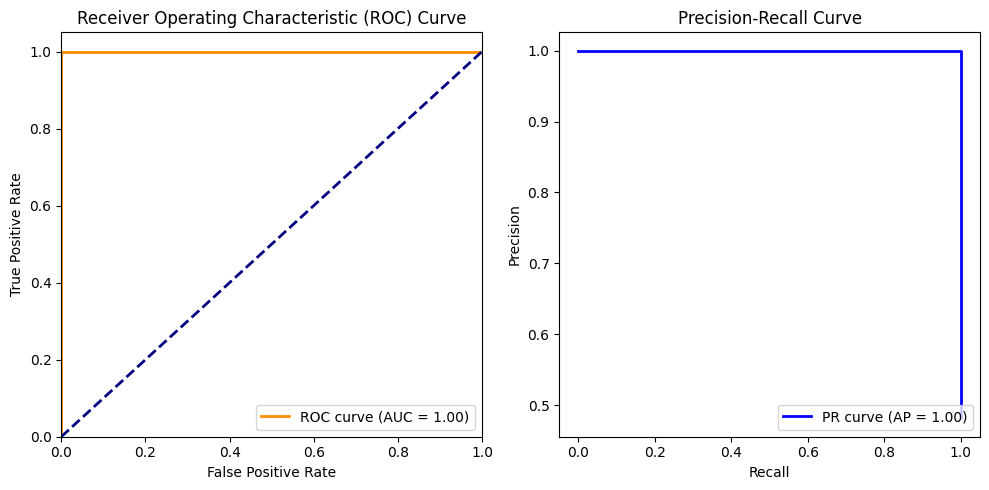


Area Under ROC Curve (AUC-ROC): 1.0
Average Precision-Recall Score (AP): 1.0


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import requests
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Download the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
response = requests.get(url)
data = StringIO(response.text)

# Load the dataset
# Column names from UCI repository documentation
columns = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
           'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
           'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
           'stalk-surface-below-ring', 'stalk-color-above-ring',
           'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
           'ring-type', 'spore-print-color', 'population', 'habitat']

df = pd.read_csv(data, names=columns)

# Convert target variable to binary (edible=0, poisonous=1)
df['class'] = df['class'].map({'e': 0, 'p': 1})

# Initialize LabelEncoder
le = LabelEncoder()

# Encode all categorical columns
X = df.drop('class', axis=1)
y = df['class']

for column in X.columns:
    X[column] = le.fit_transform(X[column])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Print model performance
print("\nModel Performance:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Get prediction probabilities for ROC curve
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve and PR area
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Print AUC-ROC and AUPRC scores
print("\nArea Under ROC Curve (AUC-ROC):", roc_auc)
print("Average Precision-Recall Score (AP):", average_precision)

In [21]:
import numpy as np

x = np.random.random(size=(100, 22))

x

array([[0.98695049, 0.47718878, 0.46134235, ..., 0.92078067, 0.74240246,
        0.75413671],
       [0.42115378, 0.55396179, 0.78257304, ..., 0.51535561, 0.36506358,
        0.11974908],
       [0.76734927, 0.22977907, 0.7985059 , ..., 0.14101511, 0.7180152 ,
        0.65282161],
       ...,
       [0.68183479, 0.87646666, 0.84992344, ..., 0.16111196, 0.51259125,
        0.93587892],
       [0.8130218 , 0.05773735, 0.38288076, ..., 0.88240881, 0.73341117,
        0.22689548],
       [0.64177591, 0.71763045, 0.4314686 , ..., 0.13604478, 0.22659275,
        0.69697363]])

In [23]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

class MushroomMIA:
    def __init__(self, n_shadow_models=10, test_size=0.2, random_state=42):
        self.n_shadow_models = n_shadow_models
        self.test_size = test_size
        self.random_state = random_state
        
        # Initialize models
        self.target_model = None
        self.shadow_models = []
        self.attack_model = None
        
        # Initialize encoders
        self.label_encoders = {}
        
        # Store feature values
        self.feature_values = {}
        
        # Store metrics
        self.metrics = {}
    
    def prepare_data(self):
        """Load and prepare mushroom dataset from UCI repository"""
        print("Loading and preparing UCI mushroom dataset...")
        
        # Load data from UCI repository
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
        
        # Column names from UCI documentation
        columns = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 
                  'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 
                  'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
                  'stalk-surface-below-ring', 'stalk-color-above-ring', 
                  'stalk-color-below-ring', 'veil-type', 'veil-color', 
                  'ring-number', 'ring-type', 'spore-print-color', 
                  'population', 'habitat']
        
        try:
            # Read data
            df = pd.read_csv(url, names=columns)
            print(f"Successfully loaded {len(df)} records with {len(columns)} features")
            
            # Separate features and target
            X = df.drop('class', axis=1)
            y = df['class']
            
            # Encode target (e=edible=0, p=poisonous=1)
            le = LabelEncoder()
            y = le.fit_transform(y)
            self.label_encoders['target'] = le
            
            # Encode features
            print("Encoding categorical features...")
            X_encoded = pd.DataFrame()
            for column in tqdm(X.columns):
                le = LabelEncoder()
                X_encoded[column] = le.fit_transform(X[column])
                self.label_encoders[column] = le
                self.feature_values[column] = le.transform(le.classes_)
            
            # Split data into train/test
            X_train, X_test, y_train, y_test = train_test_split(
                X_encoded, y, 
                test_size=self.test_size,
                random_state=self.random_state,
                stratify=y
            )
            
            print("\nDataset Statistics:")
            print(f"Training set size: {len(X_train)}")
            print(f"Test set size: {len(X_test)}")
            print(f"Number of features: {X_train.shape[1]}")
            print(f"Class distribution in training set:")
            for class_label, count in zip(*np.unique(y_train, return_counts=True)):
                print(f"  Class {class_label}: {count} samples")
            
            return X_train, X_test, y_train, y_test
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise
    
    def train_target_model(self, X_train, y_train):
        """Train the target model"""
        print("\nTraining target model...")
        self.target_model = RandomForestClassifier(n_estimators=100, random_state=self.random_state)
        self.target_model.fit(X_train, y_train)
        
        # Get training and test accuracy
        train_acc = self.target_model.score(X_train, y_train)
        print(f"Target model training accuracy: {train_acc:.3f}")
        
        return self.target_model
    
    def generate_synthetic_data(self, n_samples, n_classes):
        """Generate synthetic data for shadow models"""
        print(f"\nGenerating {n_samples} synthetic samples...")
        
        synthetic_data = []
        samples_per_class = n_samples // n_classes
        feature_names = list(self.feature_values.keys())
        
        # Generate data for each class
        for target_class in tqdm(range(n_classes), desc="Generating data for each class"):
            class_samples = []
            start_time = time.time()
            attempts = 0
            last_update = 0
            
            pbar = tqdm(total=samples_per_class, 
                       desc=f"Class {target_class} samples",
                       leave=False)
            
            while len(class_samples) < samples_per_class:
                attempts += 1
                batch_size = min(100, samples_per_class - len(class_samples))
                
                # Create DataFrame with proper feature names
                x_batch = pd.DataFrame(columns=feature_names)
                
                # Generate random categorical values
                for column in feature_names:
                    possible_values = self.feature_values[column]
                    x_batch[column] = np.random.choice(possible_values, size=batch_size)
                
                y_pred_proba = self.target_model.predict_proba(x_batch)
                confidence = np.max(y_pred_proba, axis=1)
                pred_labels = np.argmax(y_pred_proba, axis=1)
                
                good_samples = (pred_labels == target_class) & (confidence > 0.8)
                new_samples = [(x_batch.iloc[i], target_class) 
                              for i in range(len(x_batch)) if good_samples[i]]
                class_samples.extend(new_samples)
                
                new_count = len(class_samples) - last_update
                if new_count > 0:
                    pbar.update(min(new_count, samples_per_class - last_update))
                    last_update = len(class_samples)
                
                if attempts % 1000 == 0:
                    elapsed_time = time.time() - start_time
                    acceptance_rate = len(class_samples) / (attempts * batch_size)
                    pbar.set_postfix({
                        'accept_rate': f'{acceptance_rate:.3f}',
                        'time': f'{elapsed_time:.1f}s'
                    })
            
            pbar.close()
            synthetic_data.extend(class_samples[:samples_per_class])
            
            elapsed_time = time.time() - start_time
            print(f"Class {target_class} completed in {elapsed_time:.1f}s")
            print(f"Acceptance rate: {len(class_samples)/(attempts * batch_size):.3f}")
        
        print("\nShuffling and finalizing dataset...")
        np.random.shuffle(synthetic_data)
        
        # Convert to DataFrame with proper feature names
        X_synthetic = pd.DataFrame([x for x, _ in synthetic_data], columns=feature_names)
        y_synthetic = np.array([y for _, y in synthetic_data])
        
        return X_synthetic, y_synthetic
    
    def train_shadow_models(self, X_synthetic, y_synthetic):
        """Train shadow models on synthetic data"""
        print("\nTraining shadow models...")
        for i in tqdm(range(self.n_shadow_models), desc="Training shadow models"):
            # Split synthetic data
            X_shadow_train, X_shadow_test, y_shadow_train, y_shadow_test = train_test_split(
                X_synthetic, y_synthetic,
                test_size=self.test_size,
                random_state=i,
                stratify=y_synthetic
            )
            
            # Train shadow model
            shadow_model = RandomForestClassifier(n_estimators=100, random_state=i)
            shadow_model.fit(X_shadow_train, y_shadow_train)
            
            self.shadow_models.append({
                'model': shadow_model,
                'train_data': (X_shadow_train, y_shadow_train),
                'test_data': (X_shadow_test, y_shadow_test)
            })
    
    def prepare_attack_data(self):
        """Prepare data for training the attack model"""
        print("\nPreparing attack training data...")
        X_attack = []
        y_attack = []
        
        for shadow_info in tqdm(self.shadow_models, desc="Processing shadow models"):
            model = shadow_info['model']
            X_train, y_train = shadow_info['train_data']
            X_test, y_test = shadow_info['test_data']
            
            train_proba = model.predict_proba(X_train)
            test_proba = model.predict_proba(X_test)
            
            X_attack.extend(train_proba)
            y_attack.extend([1] * len(train_proba))
            
            X_attack.extend(test_proba)
            y_attack.extend([0] * len(test_proba))
        
        return np.array(X_attack), np.array(y_attack)
    
    def train_attack_model(self, X_attack, y_attack):
        """Train the attack model"""
        print("\nTraining attack model...")
        self.attack_model = RandomForestClassifier(n_estimators=100, random_state=self.random_state)
        self.attack_model.fit(X_attack, y_attack)
        
        return self.attack_model
    
    def evaluate_attack(self, X_target_train, y_target_train, X_target_test, y_target_test):
        """Evaluate the membership inference attack"""
        print("\nEvaluating attack performance...")
        
        # Get prediction probabilities
        train_proba = self.target_model.predict_proba(X_target_train)
        test_proba = self.target_model.predict_proba(X_target_test)
        
        # Combine member and non-member data
        X_eval = np.vstack([train_proba, test_proba])
        y_true = np.concatenate([np.ones(len(train_proba)), np.zeros(len(test_proba))])
        
        # Get attack predictions
        y_pred = self.attack_model.predict(X_eval)
        y_pred_proba = self.attack_model.predict_proba(X_eval)[:, 1]
        
        # Calculate metrics
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        avg_precision = average_precision_score(y_true, y_pred_proba)
        
        # Calculate confusion matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_true, y_pred)
        
        self.metrics = {
            'roc_auc': roc_auc,
            'average_precision': avg_precision,
            'fpr': fpr,
            'tpr': tpr,
            'precision': precision,
            'recall': recall,
            'confusion_matrix': cm
        }
        
        # Plot results
        plt.figure(figsize=(15, 5))
        
        # ROC curve
        plt.subplot(1, 3, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        
        # PR curve
        plt.subplot(1, 3, 2)
        plt.plot(recall, precision, color='blue', lw=2,
                label=f'PR curve (AP = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower right")
        
        # Confusion Matrix
        plt.subplot(1, 3, 3)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        
        # Add labels to confusion matrix
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
                
        plt.xticks([0, 1], ['Non-member', 'Member'])
        plt.yticks([0, 1], ['Non-member', 'Member'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        
        plt.tight_layout()
        plt.show()
        
        print("\nAttack Performance Metrics:")
        print(f"ROC AUC: {roc_auc:.3f}")
        print(f"Average Precision: {avg_precision:.3f}")
        print("\nConfusion Matrix:")
        print("True Negatives:", cm[0,0])  # Non-members correctly identified
        print("False Positives:", cm[0,1]) # Non-members incorrectly identified as members
        print("False Negatives:", cm[1,0]) # Members incorrectly identified as non-members
        print("True Positives:", cm[1,1])  # Members correctly identified
        
        # Calculate additional metrics
        accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
        precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
        recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
        
        print("\nAdditional Metrics:")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        
        return self.metrics
    
    def run_attack(self):
        """Run the complete membership inference attack pipeline"""
        # Prepare data
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        # Train target model
        self.train_target_model(X_train, y_train)
        
        # Generate synthetic data for shadow models
        n_classes = len(np.unique(y_train))
        X_synthetic, y_synthetic = self.generate_synthetic_data(
            n_samples=len(X_train),
            n_classes=n_classes
        )
        
        # Train shadow models
        self.train_shadow_models(X_synthetic, y_synthetic)
        
        # Prepare attack data
        X_attack, y_attack = self.prepare_attack_data()
        
        # Train attack model
        self.train_attack_model(X_attack, y_attack)
        
        # Evaluate attack
        metrics = self.evaluate_attack(X_train, y_train, X_test, y_test)
        
        return metrics

Initializing Membership Inference Attack...
Loading and preparing UCI mushroom dataset...
Successfully loaded 8124 records with 23 features
Encoding categorical features...


100%|██████████| 22/22 [00:00<00:00, 1137.72it/s]


Dataset Statistics:
Training set size: 6499
Test set size: 1625
Number of features: 22
Class distribution in training set:
  Class 0: 3366 samples
  Class 1: 3133 samples

Training target model...


Target model training accuracy: 1.000

Generating 6499 synthetic samples...


Generating data for each class:   0%|          | 0/2 [00:00<?, ?it/s]



















































































































Generating data for each class:  50%|█████     | 1/2 [00:13<00:13, 13.55s/it]

Class 0 completed in 13.5s
Acceptance rate: 0.947


















































































































































































































































































































































Generating data for each class: 100%|██████████| 2/2 [00:56<00:00, 28.49s/it]


Class 1 completed in 43.4s
Acceptance rate: 0.294

Shuffling and finalizing dataset...

Training shadow models...


Training shadow models: 100%|██████████| 10/10 [00:01<00:00,  5.70it/s]



Preparing attack training data...


Processing shadow models: 100%|██████████| 10/10 [00:00<00:00, 41.87it/s]



Training attack model...

Evaluating attack performance...


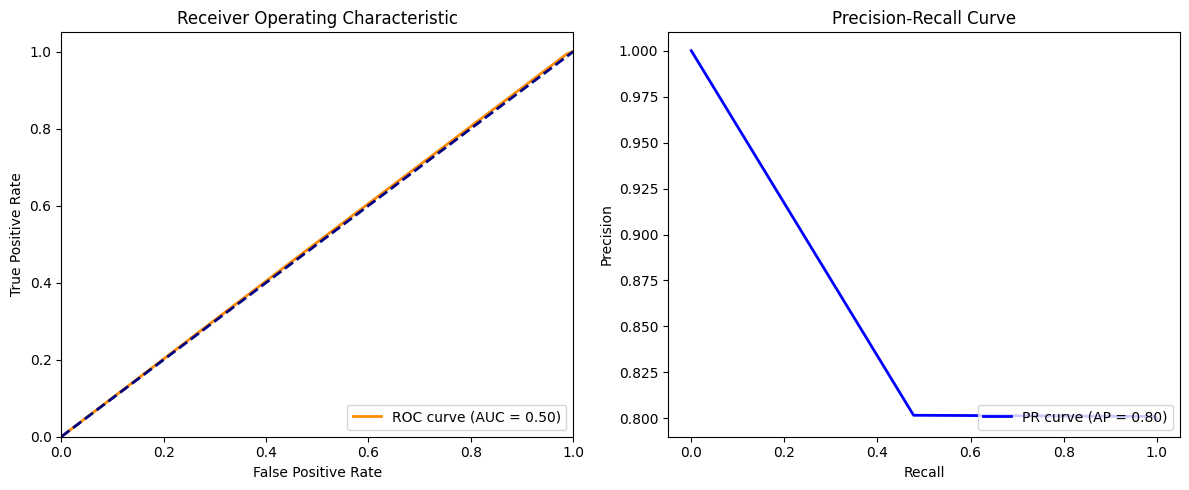


Attack Performance Metrics:
ROC AUC: 0.504
Average Precision: 0.801

Final Results:
ROC AUC Score: 0.504
Average Precision Score: 0.801


In [33]:
# Example usage
def main():
    try:
        # Initialize the attack
        print("Initializing Membership Inference Attack...")
        mia = MushroomMIA(n_shadow_models=10, test_size=0.2, random_state=42)
        
        # Run the complete attack pipeline
        metrics = mia.run_attack()
        
        # Access results
        print("\nFinal Results:")
        print(f"ROC AUC Score: {metrics['roc_auc']:.3f}")
        print(f"Average Precision Score: {metrics['average_precision']:.3f}")
        
    except Exception as e:
        print(f"Error during attack execution: {str(e)}")

if __name__ == "__main__":
    main()

In [35]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [75]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, 
                           average_precision_score, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

class MushroomMIA:
    def __init__(self, n_shadow_models=10, test_size=0.2, random_state=42):
        self.n_shadow_models = n_shadow_models
        self.test_size = test_size
        self.random_state = random_state
        self.target_model = None
        self.shadow_models = []
        self.attack_model = None
        self.label_encoders = {}
        self.feature_values = {}
        self.metrics = {}
        
    def prepare_data(self):
        """Load and prepare UCI mushroom dataset"""
        print("Loading UCI mushroom dataset...")
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
        columns = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
                  'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 
                  'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
                  'stalk-surface-below-ring', 'stalk-color-above-ring', 
                  'stalk-color-below-ring', 'veil-type', 'veil-color', 
                  'ring-number', 'ring-type', 'spore-print-color', 
                  'population', 'habitat']
        
        # Load data
        df = pd.read_csv(url, names=columns)
        print(f"Loaded {len(df)} records")
        
        # Encode features
        X = df.drop('class', axis=1)
        y = df['class'].map({'e': 0, 'p': 1})  # encode target
        
        X_encoded = pd.DataFrame()
        for column in tqdm(X.columns, desc="Encoding features"):
            le = LabelEncoder()
            X_encoded[column] = le.fit_transform(X[column])
            self.label_encoders[column] = le
            self.feature_values[column] = le.transform(le.classes_)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_encoded, y, test_size=self.test_size, 
            random_state=self.random_state, stratify=y
        )
        
        return X_train, X_test, y_train, y_test
    
    def train_target_model(self, X_train, y_train):
        """Train target model"""
        print("\nTraining target model...")
        self.target_model = RandomForestClassifier(n_estimators=100, 
                                                 random_state=self.random_state)
        self.target_model.fit(X_train, y_train)
        train_acc = self.target_model.score(X_train, y_train)
        print(f"Target model training accuracy: {train_acc:.3f}")
        return self.target_model
    
    def generate_synthetic_data(self, X_train, n_samples, n_classes):
        """Generate synthetic data for shadow models or load if already exists"""
        synthetic_file = 'synthetic_data.csv'
        if os.path.exists(synthetic_file):
            print(f"\nLoading synthetic data from {synthetic_file}...")
            synthetic_df = pd.read_csv(synthetic_file)
            X_synthetic = synthetic_df.drop('target', axis=1)
            y_synthetic = synthetic_df['target'].values
            print("Synthetic data loaded successfully!")
        else:
            print(f"\nGenerating {n_samples} synthetic samples...")
            synthetic_data = []
            samples_per_class = n_samples // n_classes
            feature_names = list(self.feature_values.keys())

            for target_class in range(n_classes):
                class_samples = []
                start_time = time.time()
                attempts = 0

                with tqdm(total=samples_per_class,
                         desc=f"Generating class {target_class} samples") as pbar:
                    while len(class_samples) < samples_per_class:
                        attempts += 1
                        batch_size = min(100, samples_per_class - len(class_samples))

                        # Generate synthetic samples
                        x_batch = pd.DataFrame(columns=feature_names)
                        for column in feature_names:
                            possible_values = self.feature_values[column]
                            x_batch[column] = np.random.choice(possible_values, size=batch_size)

                        # Get predictions
                        pred_proba = self.target_model.predict_proba(x_batch)
                        confidence = np.max(pred_proba, axis=1)
                        pred_labels = np.argmax(pred_proba, axis=1)

                        # Keep high confidence samples
                        good_samples = (pred_labels == target_class) & (confidence > 0.9)
                        new_samples = [(x_batch.iloc[i], target_class)
                                     for i in range(len(x_batch)) if good_samples[i]]
                        class_samples.extend(new_samples)

                        pbar.update(len(new_samples))

                        if attempts % 100 == 0:
                            pbar.set_postfix({
                                'accept_rate': f'{len(class_samples)/(attempts*batch_size):.3f}'
                            })

                synthetic_data.extend(class_samples[:samples_per_class])
                print(f"Class {target_class} completed in {time.time()-start_time:.1f}s")

            # Shuffle and convert to arrays
            np.random.shuffle(synthetic_data)
            X_synthetic = pd.DataFrame([x for x, _ in synthetic_data], columns=feature_names)
            y_synthetic = np.array([y for _, y in synthetic_data])

            # Save synthetic data
            synthetic_df = X_synthetic.copy()
            synthetic_df['target'] = y_synthetic
            synthetic_df.to_csv(synthetic_file, index=False)
            print(f"Saved synthetic data to {synthetic_file}")

        return X_synthetic, y_synthetic
    
    def train_shadow_models(self, X_synthetic, y_synthetic):
        """Train shadow models"""
        print("\nTraining shadow models...")
        for i in tqdm(range(self.n_shadow_models)):
            # Split synthetic data
            X_shadow_train, X_shadow_test, y_shadow_train, y_shadow_test = train_test_split(
                X_synthetic, y_synthetic, test_size=self.test_size, 
                random_state=i, stratify=y_synthetic
            )
            
            # Train shadow model
            shadow_model = RandomForestClassifier(n_estimators=100, random_state=i)
            shadow_model.fit(X_shadow_train, y_shadow_train)
            
            self.shadow_models.append({
                'model': shadow_model,
                'train_data': (X_shadow_train, y_shadow_train),
                'test_data': (X_shadow_test, y_shadow_test)
            })
    
    def prepare_attack_data(self):
        """Prepare attack training data or load if already exists"""
        attack_file = '/Users/pratheeshjp/Desktop/prof. pdeja/attack_data.csv'
        print(os.listdir('/Users/pratheeshjp/Desktop/prof. pdeja'))
        if os.path.exists(attack_file):
            print(f"\nLoading attack data from {attack_file}...")
            attack_df = pd.read_csv(attack_file)
            X_attack = attack_df.drop('is_member', axis=1).values
            y_attack = attack_df['is_member'].values
            print("Attack data loaded successfully!")
        else:
            print("\nPreparing attack data...")
            X_attack = []
            y_attack = []

            for shadow_info in tqdm(self.shadow_models):
                print(shadow_info.keys())
                model = shadow_info['model']
                X_train, y_train = shadow_info['train_data']
                X_test, y_test = shadow_info['test_data']

                # Get prediction probabilities
                train_proba = model.predict_proba(X_train)
                test_proba = model.predict_proba(X_test)

                # Concatenate probabilities with true labels
                train_features = np.column_stack((train_proba, y_train))
                test_features = np.column_stack((test_proba, y_test))

                # Add to attack data
                X_attack.extend(train_features)
                y_attack.extend([1] * len(train_features))  # members

                X_attack.extend(test_features)
                y_attack.extend([0] * len(test_features))  # non-members


            X_attack = np.array(X_attack)
            y_attack = np.array(y_attack)

            # Save attack data
            attack_df = pd.DataFrame(X_attack)
            attack_df.columns = [f'prob_class_{i}' for i in range(X_attack.shape[1])]
            attack_df['is_member'] = y_attack
            attack_df.to_csv(attack_file, index=False)
            print(f"Saved attack data to {attack_file}")

        return X_attack, y_attack

    # def prepare_attack_data(self):
    #     print("\nPreparing attack data...")
    #     X_attack = []
    #     y_attack = []

    #     for shadow_info in tqdm(self.shadow_models):
    #         print("Printing shadow_info keys")
    #         print(shadow_info.keys())
    #         model = shadow_info['model']
    #         X_train, y_train = shadow_info['train_data']
    #         X_test, y_test = shadow_info['test_data']

    #         # Get prediction probabilities
    #         train_proba = model.predict_proba(X_train)
    #         test_proba = model.predict_proba(X_test)

    #         X_attack.extend(np.concat((train_proba, y_train), axis=0))
    #         y_attack.extend([1] * len(train_proba))  # members

    #         X_attack.extend(np.concat((test_proba, y_test), axis=0))
    #         y_attack.extend([0] * len(test_proba))  # non-members

    #     X_attack = np.array(X_attack)
    #     y_attack = np.array(y_attack)

    #     # # Save attack data
    #     # attack_df = pd.DataFrame(X_attack)
    #     # attack_df.columns = [f'prob_class_{i}' for i in range(X_attack.shape[1])]
    #     # attack_df['is_member'] = y_attack
    #     # attack_df.to_csv(attack_file, index=False)
    #     # print(f"Saved attack data to {attack_file}")

    #     return X_attack, y_attack


    def plot_distributions(self, X_train, X_synthetic, X_attack, y_attack):
        """Plot data distributions"""
        # Feature distributions
        plt.figure(figsize=(15, 10))
        plt.suptitle('Feature Distributions: Training vs Synthetic Data')
        
        n_features = X_train.shape[1]
        n_cols = 4
        n_rows = (n_features + n_cols - 1) // n_cols
        
        for i, feature in enumerate(X_train.columns):
            plt.subplot(n_rows, n_cols, i+1)
            
            # Plot training distribution
            plt.hist(X_train[feature], bins=20, alpha=0.5, 
                    density=True, label='Training', color='blue')
            
            # Plot synthetic distribution
            plt.hist(X_synthetic[feature], bins=20, alpha=0.5,
                    density=True, label='Synthetic', color='red')
            
            plt.title(feature, fontsize=8)
            if i == 0:
                plt.legend()
            plt.xticks(rotation=45, fontsize=6)
            plt.yticks(fontsize=6)
        
        plt.tight_layout()
        plt.savefig('feature_distributions.png')
        plt.show()
        
        # Attack probabilities distribution
        plt.figure(figsize=(15, 5))
        plt.suptitle('Attack Model Prediction Distributions')
        
        for i in range(X_attack.shape[1]):
            plt.subplot(1, X_attack.shape[1], i+1)
            
            # Plot member probabilities
            plt.hist(X_attack[y_attack==1, i], bins=20, alpha=0.5,
                    density=True, label='Members', color='blue')
            
            # Plot non-member probabilities
            plt.hist(X_attack[y_attack==0, i], bins=20, alpha=0.5,
                    density=True, label='Non-members', color='red')
            
            plt.title(f'Class {i} Probability')
            if i == 0:
                plt.legend()
        
        plt.tight_layout()
        plt.savefig('attack_distributions.png')
        plt.show()
    
    def evaluate_attack(self, X_target_train, y_target_train, X_target_test, y_target_test):
        """Evaluate attack performance, including class-specific accuracy"""
        print("\nEvaluating attack performance...")
        
        # Get predictions
        train_proba = self.target_model.predict_proba(X_target_train)
        test_proba = self.target_model.predict_proba(X_target_test)
        
        X_eval = np.vstack([train_proba, test_proba])
        y_true = np.concatenate([np.ones(len(train_proba)), np.zeros(len(test_proba))])
        
        y_pred = self.attack_model.predict(X_eval)
        y_pred_proba = self.attack_model.predict_proba(X_eval)[:, 1]
        
        # Calculate metrics
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        avg_precision = average_precision_score(y_true, y_pred_proba)
        
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate class-specific accuracy
        y_true_members = y_true[y_true == 1]  # Members
        y_pred_members = y_pred[y_true == 1]
        member_accuracy = np.mean(y_true_members == y_pred_members)
        
        y_true_non_members = y_true[y_true == 0]  # Non-members
        y_pred_non_members = y_pred[y_true == 0]
        non_member_accuracy = np.mean(y_true_non_members == y_pred_non_members)
        
        # Plot results
        plt.figure(figsize=(15, 5))
        
        # ROC curve
        plt.subplot(1, 3, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        
        # PR curve
        plt.subplot(1, 3, 2)
        plt.plot(recall, precision, color='blue', lw=2,
                label=f'PR (AP = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        
        # Confusion matrix
        plt.subplot(1, 3, 3)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-member', 'Member'],
                yticklabels=['Non-member', 'Member'])
        plt.title('Confusion Matrix')
        
        plt.tight_layout()
        plt.savefig('attack_evaluation.png')
        plt.show()
        
        # Print metrics
        print("\nAttack Performance Metrics:")
        print(f"ROC AUC: {roc_auc:.3f}")
        print(f"Average Precision: {avg_precision:.3f}")
        print("\nConfusion Matrix:")
        print(f"True Negatives: {cm[0,0]}")
        print(f"False Positives: {cm[0,1]}")
        print(f"False Negatives: {cm[1,0]}")
        print(f"True Positives: {cm[1,1]}")
        
        accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
        precision = cm[1,1] / (cm[1,1] + cm[0,1])
        recall = cm[1,1] / (cm[1,1] + cm[1,0])
        f1 = 2 * (precision * recall) / (precision + recall)
        
        print(f"\nOverall Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1 Score: {f1:.3f}")
        
        # Print class-specific accuracy
        print("\nClass-Specific Accuracy:")
        print(f"Member Accuracy: {member_accuracy:.3f}")
        print(f"Non-Member Accuracy: {non_member_accuracy:.3f}")
        
        return {
            'roc_auc': roc_auc,
            'average_precision': avg_precision,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'member_accuracy': member_accuracy,
            'non_member_accuracy': non_member_accuracy
        }
    
    def visualize_tsne_clusters(self, X_test, y_test, X_synthetic, y_synthetic):
        """
        Visualize t-SNE clusters for test and synthetic data, separated by class
        """
        from sklearn.manifold import TSNE
        import matplotlib.pyplot as plt
        
        # Combine data for t-SNE
        X_combined = np.vstack([X_test, X_synthetic])
        
        # Create labels for plotting
        data_labels = np.array(['test'] * len(X_test) + ['synthetic'] * len(X_synthetic))
        class_labels = np.concatenate([y_test, y_synthetic])
        
        # Fit t-SNE
        print("Fitting t-SNE...")
        tsne = TSNE(n_components=2, random_state=self.random_state, perplexity=30)
        X_tsne = tsne.fit_transform(X_combined)
        
        # Split back into test and synthetic
        X_tsne_test = X_tsne[:len(X_test)]
        X_tsne_synthetic = X_tsne[len(X_test):]
        
        # Plot
        plt.figure(figsize=(15, 6))
        
        # Plot Class 0
        plt.subplot(1, 2, 1)
        plt.title('Class 0 Distribution')
        
        # Test data points for class 0
        mask_test_0 = (data_labels == 'test') & (class_labels == 0)
        plt.scatter(X_tsne[mask_test_0, 0], X_tsne[mask_test_0, 1], 
                    c='blue', label='Test Class 0', alpha=0.6)
        
        # Synthetic data points for class 0
        mask_synth_0 = (data_labels == 'synthetic') & (class_labels == 0)
        plt.scatter(X_tsne[mask_synth_0, 0], X_tsne[mask_synth_0, 1], 
                    c='lightblue', label='Synthetic Class 0', alpha=0.6)
        
        plt.legend()
        plt.xlabel('t-SNE-1')
        plt.ylabel('t-SNE-2')
        
        # Plot Class 1
        plt.subplot(1, 2, 2)
        plt.title('Class 1 Distribution')
        
        # Test data points for class 1
        mask_test_1 = (data_labels == 'test') & (class_labels == 1)
        plt.scatter(X_tsne[mask_test_1, 0], X_tsne[mask_test_1, 1], 
                    c='red', label='Test Class 1', alpha=0.6)
        
        # Synthetic data points for class 1
        mask_synth_1 = (data_labels == 'synthetic') & (class_labels == 1)
        plt.scatter(X_tsne[mask_synth_1, 0], X_tsne[mask_synth_1, 1], 
                    c='lightcoral', label='Synthetic Class 1', alpha=0.6)
        
        plt.legend()
        plt.xlabel('t-SNE-1')
        plt.ylabel('t-SNE-2')
        
        plt.tight_layout()
        plt.savefig('tsne_clusters.png')
        plt.show()
        
        # Calculate and print overlap metrics
        def calculate_overlap(points1, points2):
            from scipy.spatial.distance import cdist
            
            # Calculate pairwise distances between all points
            distances = cdist(points1, points2)
            
            # Define a threshold for considering points as overlapping
            threshold = np.mean(distances) / 2
            
            # Count points that have at least one neighbor within threshold
            overlap_count1 = np.sum(np.min(distances, axis=1) < threshold) / len(points1)
            overlap_count2 = np.sum(np.min(distances.T, axis=1) < threshold) / len(points2)
            
            return (overlap_count1 + overlap_count2) / 2
        
        # Calculate overlap for each class
        test_0 = X_tsne[mask_test_0]
        synth_0 = X_tsne[mask_synth_0]
        overlap_0 = calculate_overlap(test_0, synth_0)
        
        test_1 = X_tsne[mask_test_1]
        synth_1 = X_tsne[mask_synth_1]
        overlap_1 = calculate_overlap(test_1, synth_1)
        
        print("\nCluster Overlap Metrics:")
        print(f"Class 0 overlap: {overlap_0:.3f}")
        print(f"Class 1 overlap: {overlap_1:.3f}")
        
        return {
            'overlap_class_0': overlap_0,
            'overlap_class_1': overlap_1,
            'tsne_coordinates': X_tsne,
            'data_labels': data_labels,
            'class_labels': class_labels
        }
    

    def visualize_attack_clusters(self, X_attack, y_attack):
        """
        Visualize t-SNE clusters for attack data (members vs non-members) for each class
        """
        from sklearn.manifold import TSNE
        import matplotlib.pyplot as plt
        
        # Fit t-SNE
        print("\nFitting t-SNE on attack data...")
        tsne = TSNE(n_components=2, random_state=self.random_state, perplexity=30)
        X_tsne = tsne.fit_transform(X_attack)
        
        # Plot
        plt.figure(figsize=(15, 6))
        
        # Plot Class 0 probabilities
        plt.subplot(1, 2, 1)
        plt.title('Class 0 Probability Distribution (Members vs Non-Members)')
        
        # Member points
        mask_members = y_attack == 1
        plt.scatter(X_tsne[mask_members, 0], X_tsne[mask_members, 1],
                    c='blue', label='Members', alpha=0.6)
        
        # Non-member points
        mask_non_members = y_attack == 0
        plt.scatter(X_tsne[mask_non_members, 0], X_tsne[mask_non_members, 1],
                    c='red', label='Non-Members', alpha=0.6)
        
        plt.legend()
        plt.xlabel('t-SNE-1')
        plt.ylabel('t-SNE-2')
        
        # Calculate overlap for probabilities
        def calculate_overlap(points1, points2):
            from scipy.spatial.distance import cdist
            
            # Calculate pairwise distances between all points
            distances = cdist(points1, points2)
            
            # Define a threshold for considering points as overlapping
            threshold = np.mean(distances) / 2
            
            # Count points that have at least one neighbor within threshold
            overlap_count1 = np.sum(np.min(distances, axis=1) < threshold) / len(points1)
            overlap_count2 = np.sum(np.min(distances.T, axis=1) < threshold) / len(points2)
            
            return (overlap_count1 + overlap_count2) / 2
        
        # Calculate overlap between members and non-members
        member_points = X_tsne[mask_members]
        non_member_points = X_tsne[mask_non_members]
        overlap = calculate_overlap(member_points, non_member_points)
        
        plt.title(f'Probability Distribution\nOverlap between Members and Non-Members: {overlap:.3f}')
        
        # Add density plot
        plt.subplot(1, 2, 2)
        plt.title('Probability Density Distribution')
        
        # Plot member probabilities
        member_probs = X_attack[mask_members, 0]  # Class 0 probabilities for members
        plt.hist(member_probs, bins=30, alpha=0.5, density=True, 
                label='Members', color='blue')
        
        # Plot non-member probabilities
        non_member_probs = X_attack[mask_non_members, 0]  # Class 0 probabilities for non-members
        plt.hist(non_member_probs, bins=30, alpha=0.5, density=True,
                label='Non-Members', color='red')
        
        plt.xlabel('Probability')
        plt.ylabel('Density')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('attack_clusters.png')
        plt.show()
        
        # Print statistics
        print("\nAttack Data Statistics:")
        print(f"Number of members: {np.sum(mask_members)}")
        print(f"Number of non-members: {np.sum(mask_non_members)}")
        print(f"Overlap between members and non-members: {overlap:.3f}")
        
        # Calculate and print probability statistics
        print("\nProbability Statistics:")
        print("Members:")
        print(f"Mean probability: {np.mean(member_probs):.3f}")
        print(f"Std probability: {np.std(member_probs):.3f}")
        print("\nNon-Members:")
        print(f"Mean probability: {np.mean(non_member_probs):.3f}")
        print(f"Std probability: {np.std(non_member_probs):.3f}")
        
        return {
            'overlap': overlap,
            'tsne_coordinates': X_tsne,
            'member_mask': mask_members,
            'non_member_mask': mask_non_members
        }

    def run_attack(self):
        """Run complete attack pipeline"""
        try:
            # Load and prepare data
            X_train, X_test, y_train, y_test = self.prepare_data()

            # Train target model
            self.train_target_model(X_train, y_train)

            # Generate synthetic data or load if exists
            n_classes = len(np.unique(y_train))
            X_synthetic, y_synthetic = self.generate_synthetic_data(
                X_train, len(X_train), n_classes
            )


            n_classes = len(np.unique(y_train))
            X_synthetic, y_synthetic = self.generate_synthetic_data(X_train, len(X_train), n_classes)

            # Add t-SNE visualization
            # print("\nGenerating t-SNE visualization...")
            # tsne_metrics = self.visualize_tsne_clusters(X_test, y_test, X_synthetic, y_synthetic)

            # print(tsne_metrics)

        #     # Train shadow models
            self.train_shadow_models(X_synthetic, y_synthetic)

        #     # Prepare attack data or load if exists
            X_attack, y_attack = self.prepare_attack_data()


            print("\nGenerating attack data visualization...")
            attack_viz_metrics = self.visualize_attack_clusters(X_attack, y_attack)
            
            # Print overlap metrics
            print("\nAttack Data Overlap Metrics:")
            print(f"Member vs Non-Member overlap: {attack_viz_metrics['overlap']:.3f}")

            # Continue with the rest of the method...
            # Plot distributions
            self.plot_distributions(X_train, X_synthetic, X_attack, y_attack)

        #     # Plot distributions
        #     self.plot_distributions(X_train, X_synthetic, X_attack, y_attack)

        #     # Calculate class weights
        #     class_counts = np.bincount(y_attack)
        #     total_samples = np.sum(class_counts)
        #     class_weights = {
        #         class_label: total_samples / (len(class_counts) * class_count)
        #         for class_label, class_count in enumerate(class_counts)
        #     }
        #     # class_weights = {0: 0.7, 1: 0.3}

        #     print("\nClass Weights:", class_weights)

        #     a = {0: np.float64(2.499230769230769), 1: np.float64(0.6250480954213159)}
        #     print("****************************************************************************************",class_weights)

        #     # Train attack model
        #     print("\nTraining attack model...")
        #     self.attack_model = RandomForestClassifier(n_estimators=100,
        #                                              random_state=self.random_state, class_weight=class_weights)
        #     self.attack_model.fit(X_attack, y_attack)

        #     # Evaluate attack
        #     metrics = self.evaluate_attack(X_train, y_train, X_test, y_test)

        #     return metrics

        except Exception as e:
            print(f"Error during attack: {str(e)}")
            raise

if __name__ == "__main__":
    print("Starting Membership Inference Attack on UCI Mushroom Dataset...")
    print("=" * 80)
    
    try:
        # Initialize and run attack
        mia = MushroomMIA(n_shadow_models=10)
        metrics = mia.run_attack()
        
        # Print final summary
        print("\nAttack completed successfully!")
        print("=" * 80)
        print("\nFinal Performance Metrics:")
        print(f"ROC AUC Score: {metrics['roc_auc']:.3f}")
        print(f"Average Precision: {metrics['average_precision']:.3f}")
        print(f"Accuracy: {metrics['accuracy']:.3f}")
        print(f"Precision: {metrics['precision']:.3f}")
        print(f"Recall: {metrics['recall']:.3f}")
        print(f"F1 Score: {metrics['f1']:.3f}")
        
        print("\nConfusion Matrix:")
        cm = metrics['confusion_matrix']
        print(f"True Negatives: {cm[0,0]}")
        print(f"False Positives: {cm[0,1]}")
        print(f"False Negatives: {cm[1,0]}")
        print(f"True Positives: {cm[1,1]}")
        
        print("\nSaved Files:")
        print("- synthetic_data.csv")
        print("- attack_data.csv")
        print("- feature_distributions.png")
        print("- attack_distributions.png")
        print("- attack_evaluation.png")
        
    except Exception as e:
        print(f"\nError during execution: {str(e)}")
        raise

Starting Membership Inference Attack on UCI Mushroom Dataset...
Loading UCI mushroom dataset...
Loaded 8124 records


Encoding features: 100%|██████████| 22/22 [00:00<00:00, 962.31it/s]


Training target model...
Target model training accuracy: 1.000

Loading synthetic data from synthetic_data.csv...


Synthetic data loaded successfully!

Loading synthetic data from synthetic_data.csv...
Synthetic data loaded successfully!

Training shadow models...


100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


['synthetic_labels.npy', 'attack_distributions.png', '.DS_Store', 's41467-020-19669-x.pdf', 'RVCE', 'attack_data.csv', 'attack_evaluation.png', 's13073-020-00803-9 (5).pdf', 'dbNSFP5.0a.zip', 'synthetic_data.npy', 'generating-synthetic-data-for-medical-imaging.pdf', 'feature_distributions.png', 'tsne_clusters.png', '2103.07853v4.pdf', 'Hunter_MolecularBiology.pdf', 'dbNSFP5.0a', 'Mia.ipynb', 'synthetic_data.csv', 'mia.pdf', 'REVEL.pdf']

Loading attack data from /Users/pratheeshjp/Desktop/prof. pdeja/attack_data.csv...
Attack data loaded successfully!

Generating attack data visualization...

Fitting t-SNE on attack data...


KeyboardInterrupt: 

In [74]:
# data  =  pd.read_csv('attack_data.csv')

# data.head()

!ls
# data.is_member.value_counts()

2103.07853v4.pdf
Hunter_MolecularBiology.pdf
Mia.ipynb
REVEL.pdf
RVCE
attack_data.csv
attack_distributions.png
attack_evaluation.png
dbNSFP5.0a
dbNSFP5.0a.zip
feature_distributions.png
generating-synthetic-data-for-medical-imaging.pdf
mia.pdf
s13073-020-00803-9 (5).pdf
s41467-020-19669-x.pdf
synthetic_data.csv
synthetic_data.npy
synthetic_labels.npy
tsne_clusters.png


In [72]:
! pwd

/Users/pratheeshjp/Desktop/prof. pdeja
